# Compare Growth Profiles

One question I've had is how much the wake affects bubble growth. Before developing the software to store the wake data with the bubble data, I want to explore the bubble growth data to see how much the growth of different bubbles varies.

Here, I plot the growth of different bubbles together. Ultimately, I want to find a way to collapse those that are part of the same growth trajectory onto a family of curves. I believe Alex Lennon of the Swan group described a method for doing this that had the word "Gaussian" in it.

In [1]:
%load_ext autoreload
%autoreload 2

# sets plotting font to Arial
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

# standard libraries
import os
import glob
import pickle as pkl

# 3rd party libraries
import numpy as np
import matplotlib.pyplot as plt

# custom libraries
import sys
sys.path.append('../../libs/')
import fn
import flow
import plot.bubble as pltb
from conversions import *

# comes after imports from ../../libs/ because I unfortunately 
# created files with the same name there and in ../src/
sys.path.append('../src/')
import objproc as op
import bubble
import analytics as an

### PARAMETERS ###
# directory template containing data files
data_dir_tmp = '../input/ppg_co2/20211202_72bar/*'
# data filename
data_filename = 'data.pkl'
# data for polyol-CO2 mixture 
# make this on Wang group server with `bi_surf`--read README.txt and copy 1k3f_22c.csv
polyol_data_file = '../input/3k2f_31c.csv'
# equation of state data for CO2 at desired temperature 
eos_co2_file = '../input/eos_co2_25-0C.csv'

## Load Data

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


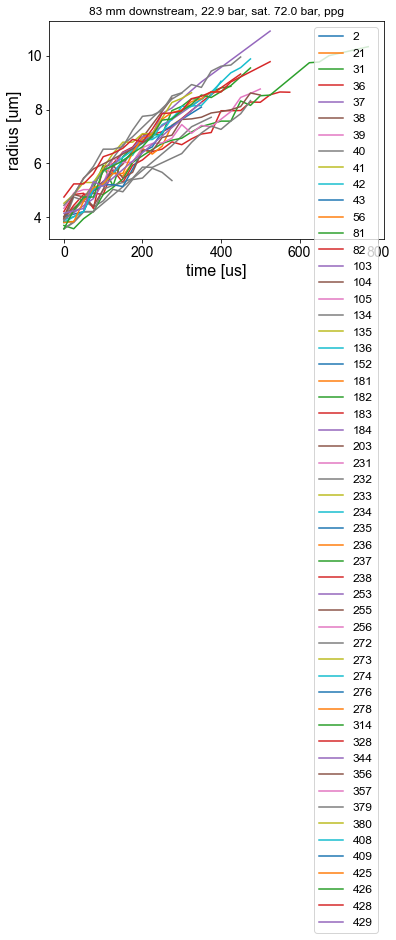

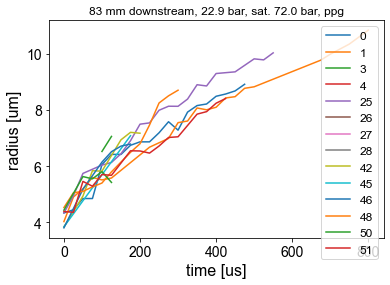

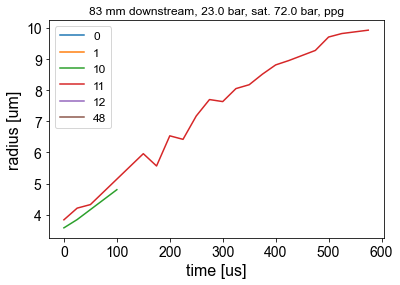

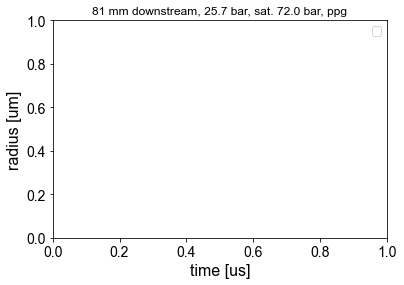

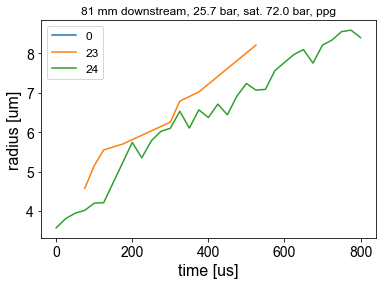

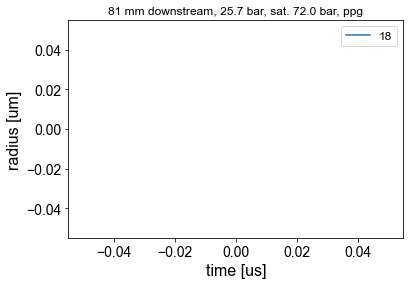

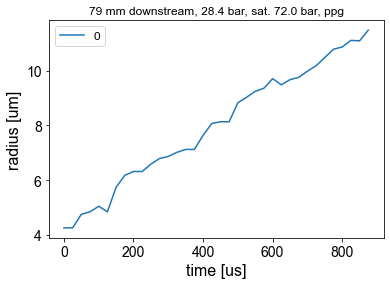

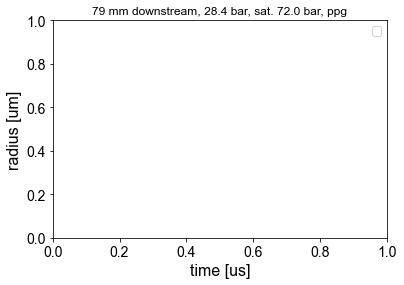

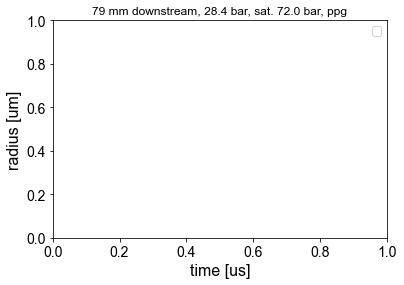

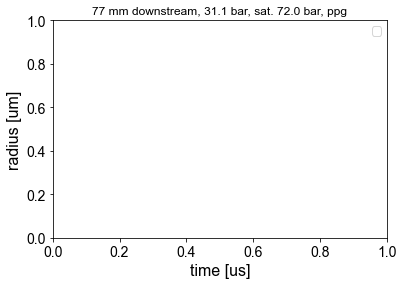

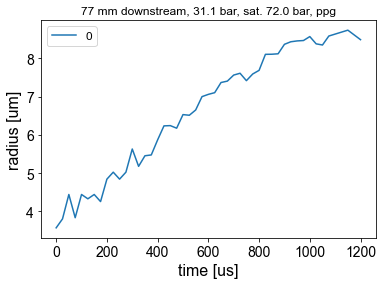

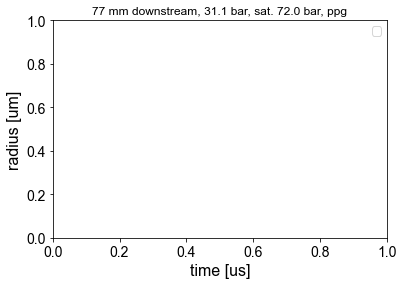

In [3]:
# plot parameters
ax_fs = 16
tk_fs = 14
l_fs = 12
# analysis parameters
W_frac = 0.5 # ignores all bubbles for which width is less than this fraction of length


# data structs to store bubble radii, etc.
# keys will be (num, ID), where num is video number and ID is bubble ID number
# values will be dictionaries of properties: time [s], radius [m], width [m], length [m],
# 
bubble_growth = {}

# loads data from each file
data_dir_list = glob.glob(data_dir_tmp)
for data_dir in data_dir_list:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    with open(os.path.join(data_dir, data_filename), 'rb') as f:
        data = pkl.load(f)
        
    # gets conditions
    # saturation pressure, distance along capillary, 
    # estimated local pressure, polyol
    p_in, p_sat, p_est, d, L, v_max, t_center, polyol, num = op.get_conditions(data['metadata'])

    # gets sizes of each bubble
    for ID, obj in data['objects'].items():
        # skips objects that are not definitely real objects (bubbles)
        if not op.is_true_obj(obj):
            continue
        
        # gets timeline of bubble (starts at zero) [s]
        frame_list = obj['props_raw']['frame']
        fps = obj['metadata']['fps']
        t = (np.asarray(frame_list) - frame_list[0]) / fps
        
        # gets bubble size
        R = np.asarray(obj['props_proc']['radius [um]'])
        L = np.asarray(op.calc_L(obj))
        W = np.asarray(op.calc_W(obj))
        
        # gets valid indices (eliminates where on border or where bubble is too long
        not_on_border = np.logical_not(np.asarray(obj['props_raw']['on border']))
        not_too_long = W > L*W_frac
        idx = np.logical_and(not_on_border, not_too_long)
        
        # plots bubble growth
        ax.plot(t[idx]*s_2_us, R[idx], label=str(ID))
        
        
    # formats plot
    ax.set_xlabel('time [us]', fontsize=ax_fs)
    ax.set_ylabel('radius [um]', fontsize=ax_fs)
    ax.tick_params(axis='both', labelsize=tk_fs)
    ax.legend(fontsize=l_fs)
    ax.set_title('{0:d} mm downstream, {1:.1f} bar, sat. {2:.1f} bar, {3:s}'\
                 .format(int(d*m_2_mm), p_est*Pa_2_bar, p_sat*Pa_2_bar, polyol))

## Scale Assuming Linear Growth

Based on the growth profiles above, I will first try to collapse the data by assuming linear growth. Collapsing linear data is simple as shifting so the linear fit passes through the origin.

C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\IPython\core\interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


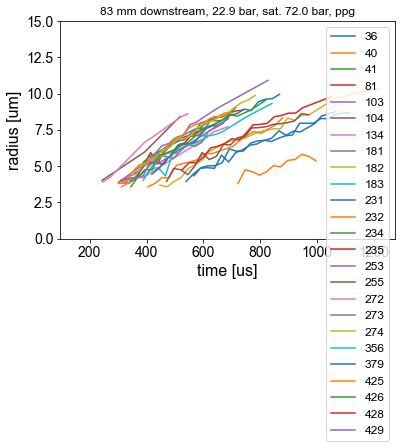

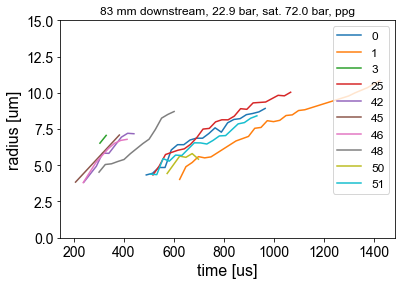

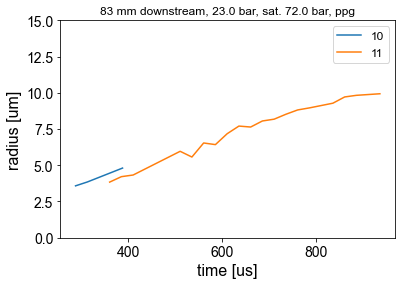

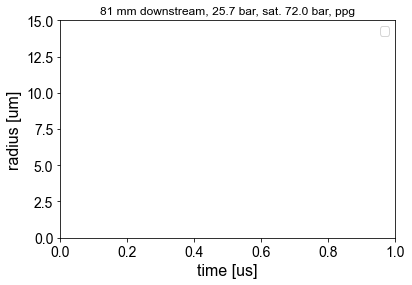

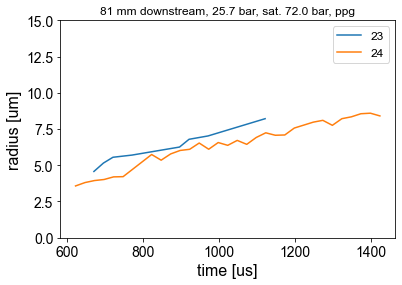

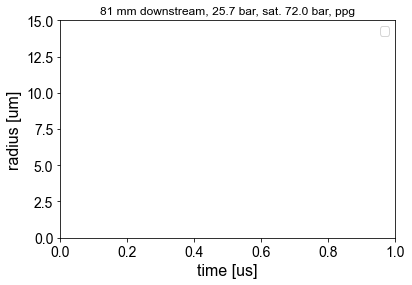

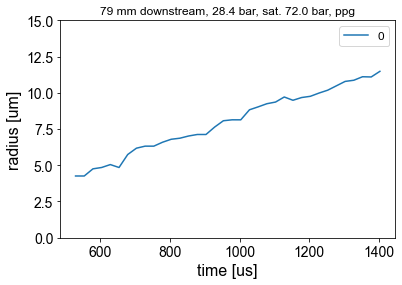

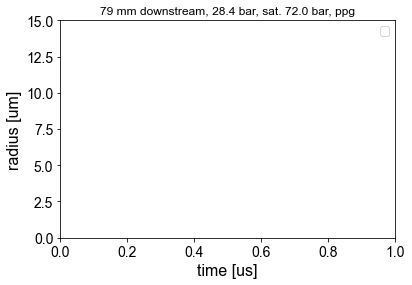

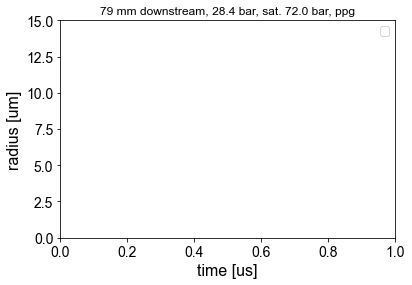

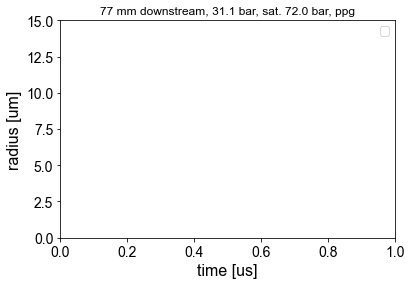

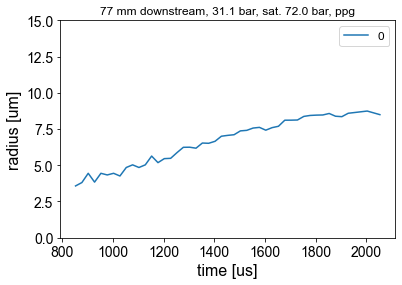

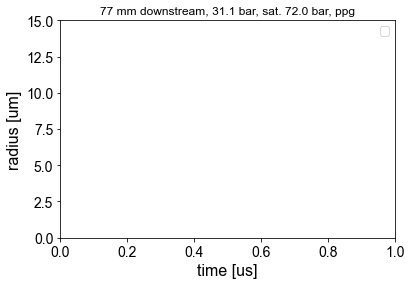

In [9]:
# plot parameters
ax_fs = 16
tk_fs = 14
l_fs = 12
# analysis parameters
W_frac = 0.5 # ignores all bubbles for which width is less than this fraction of length


# data structs to store bubble radii, etc.
# keys will be (num, ID), where num is video number and ID is bubble ID number
# values will be dictionaries of properties: time [s], radius [m], width [m], length [m],
# 
bubble_growth = {}

# loads data from each file
data_dir_list = glob.glob(data_dir_tmp)
for data_dir in data_dir_list:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    with open(os.path.join(data_dir, data_filename), 'rb') as f:
        data = pkl.load(f)
        
    # gets conditions
    # saturation pressure, distance along capillary, 
    # estimated local pressure, polyol
    p_in, p_sat, p_est, d, L, v_max, t_center, polyol, num = op.get_conditions(data['metadata'])

    # gets sizes of each bubble
    for ID, obj in data['objects'].items():
        # skips objects that are not definitely real objects (bubbles)
        if not op.is_true_obj(obj):
            continue
        
        # gets timeline of bubble (starts at zero) [s]
        frame_list = obj['props_raw']['frame']
        fps = obj['metadata']['fps']
        t = (np.asarray(frame_list) - frame_list[0]) / fps
        
        # gets bubble size
        R = np.asarray(obj['props_proc']['radius [um]'])
        L = np.asarray(op.calc_L(obj))
        W = np.asarray(op.calc_W(obj))
        
        # gets valid indices (eliminates where on border or where bubble is too long
        not_on_border = np.logical_not(np.asarray(obj['props_raw']['on border']))
        not_too_long = W > L*W_frac
        idx = np.logical_and(not_on_border, not_too_long)
        if len(t[idx]) == 0:
            continue
        
        ################################################################
        # Computes shift in time for collapse onto linear growth profile
        a, b = np.polyfit(t[idx], R[idx], 1)
        t_shift = b / a # shifts so line of best fit passes through origin
        # plots bubble growth
        ax.plot((t[idx] + t_shift)*s_2_us, R[idx], label=str(ID))
        
        
    # formats plot
    ax.set_xlabel('time [us]', fontsize=ax_fs)
    ax.set_ylabel('radius [um]', fontsize=ax_fs)
    ax.tick_params(axis='both', labelsize=tk_fs)
    ax.set_ylim([0, 15])
    ax.legend(fontsize=l_fs)
    ax.set_title('{0:d} mm downstream, {1:.1f} bar, sat. {2:.1f} bar, {3:s}'\
                 .format(int(d*m_2_mm), p_est*Pa_2_bar, p_sat*Pa_2_bar, polyol))